In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/labs/amit/noamsh/repos/sc_clustering')

In [2]:
import numpy as np
import anndata as ad
import scanpy as sc
import scvi

from pathlib import Path

import config

## config

In [3]:
experiment_name = "mc_2021_09_23__09_59_00"
experiment_results_dir_path = Path(config.RESULTS_DIR, experiment_name)

sc.settings.figdir=Path(experiment_results_dir_path, "figures")

## load data

In [4]:
adata = ad.read_h5ad(Path(experiment_results_dir_path, "metacells.h5ad"))


In [5]:
adata_with_scanpy = ad.read_h5ad(Path(experiment_results_dir_path, "scanpy_metacells.h5ad"))

In [6]:
adata.obs['broad_cell_type'] = adata_with_scanpy.obs['broad_cell_type']
adata.obs['leiden'] = adata_with_scanpy.obs['leiden']
adata.obs['cell_type'] = adata_with_scanpy.obs['cell_type']

## pp

In [14]:
sc.pp.filter_cells(adata, min_genes=200) # filter cells with fewer than 200 genes
sc.pp.filter_cells(adata, min_counts=200)  # This is a weaker threshold than above. It is just to population the n_counts column in adata
sc.pp.filter_genes(adata, min_cells=2) # filter genes detected in fewer than 3 cells

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## feature selection

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=3, min_disp=0.8)
adata.var['highly_variable']=np.logical_or(adata.var['highly_variable'],adata.var.feature_gene>3)

## scvi

In [15]:
scvi.data.setup_anndata(adata)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2651 cells, 22525 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [16]:
model = scvi.model.SCVI(adata, n_hidden=64)
model

SCVI Model with the following params: 
n_hidden: 64, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [17]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|██████████| 400/400 [12:52<00:00,  1.93s/it, loss=2.58e+04, v_num=1]


In [18]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [19]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=10)
sc.tl.umap(adata, min_dist=0.2)

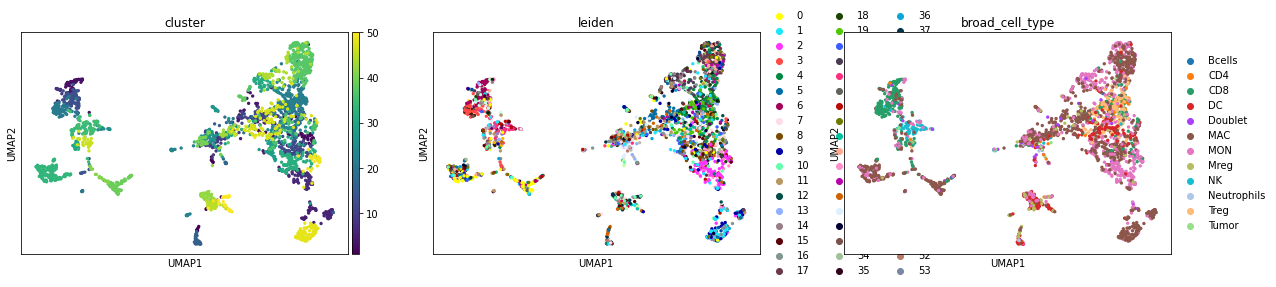

In [20]:
sc.pl.umap(adata, color=["cluster", "leiden", "broad_cell_type"], save="_unnormelized_full_data_n_neighbors_10_hidden_64_gpu")


## cluster

In [17]:
sc.tl.leiden(adata, key_added="leiden_scVI")

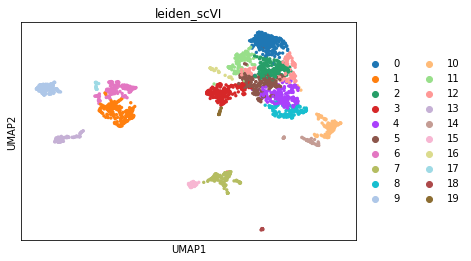

In [18]:
sc.pl.umap(adata, color=["leiden_scVI"])


## after scvi



In [8]:
example_model = "hp_search_scvi_on_meta_cells_2021_09_26__11_24_15/hidden_64_layers_2_latent_30_neighbors_10_dropout_0.1_epochs_600"
adata_after = ad.read_h5ad(Path(config.RESULTS_DIR, example_model, "adata_with_annot_and_scvi.h5ad"))

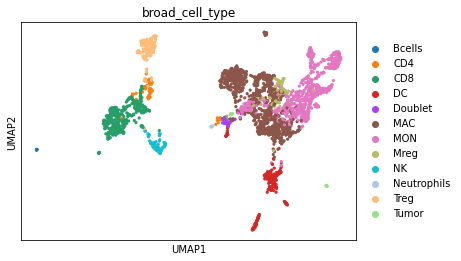

In [16]:
sc.pl.umap(adata_after, color=["broad_cell_type"])

In [17]:
# adata_after.obsm["X_scVI"].shape
adata_after.obs["broad_cell_type"]

0       Doublet
1       Doublet
2       Doublet
3           CD8
4            DC
         ...   
2921       Treg
2922         NK
2923       Treg
2924         NK
2925         NK
Name: broad_cell_type, Length: 2926, dtype: category
Categories (12, object): ['Bcells', 'CD4', 'CD8', 'DC', ..., 'NK', 'Neutrophils', 'Treg', 'Tumor']

In [18]:
from sklearn.metrics import silhouette_score

silhouette_score(adata_after.obsm["X_scVI"], labels=list(adata_after.obs["broad_cell_type"]))

0.19693384